top 1 validation accuracy

In [1]:
import os
Task_name = 'Assignment1&2 dataset'
data_root = "/home/p88101029/"
raw_data_base = os.path.join(data_root,Task_name)
os.makedirs(raw_data_base, exist_ok=True)

In [21]:
listoffolder=sorted(os.listdir(raw_data_base), reverse=False)

open and save image

In [22]:
import cv2
import numpy as np
from numpy import asarray
images = []
imagescat = []
imagesnames = []
for folder in listoffolder:
    images_path = os.path.join(raw_data_base,folder)
    address = sorted(os.listdir(images_path))
    for imgadd in address:
        imagescat.append(folder)
        imagesnames.append(imgadd)
        img=cv2.imread(os.path.join(images_path,imgadd))
        images.append(asarray(img))


transform image to HOG features

In [23]:
winSize=(64,64)
blockSize=(16,16)
blockStride=(8,8)
cellSize=(8,8)
nbins=9
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)

In [24]:
padding=(0,0)
winStride=(8, 8)
imginhog=[]
for i in images:
    img=hog.compute(cv2.resize(i,(64,64)), winStride=winStride, padding=padding)
    imginhog.append(img)

In [25]:
imginhogarr=np.asarray(imginhog).reshape(64225, np.asarray(imginhog).shape[1])
imagescatarr=np.asarray(imagescat)

save / load features dataset

In [47]:
np.save('imginhogarr', imginhogarr)
np.save('imagescatarr', imagescatarr)

In [2]:
import cv2
import numpy as np
from numpy import asarray
imginhogarr=np.load('imginhogarr.npy')
imagescatarr=np.load('imagescatarr.npy')

split dataset into train/valid/test

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
X_trainvalid, X_test, y_trainvalid, y_test = train_test_split(imginhogarr,imagescatarr, test_size=0.1, random_state=0)
#X_train, X_valid, y_train, y_valid = train_test_split(X_trainvalid,y_trainvalid, test_size=0.2, random_state=0)
split_index = np.concatenate((np.ones(round(len(y_trainvalid)*0.8))*-1, np.zeros(round(len(y_trainvalid)*0.2))), axis=None)
pds = PredefinedSplit(test_fold = split_index)

develop LSVC model

In [6]:
from sklearn.svm import LinearSVC
svm=LinearSVC(penalty="l2", dual = False ,max_iter=10000,random_state=0)

In [7]:
#fit model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
clf = GridSearchCV(estimator=svm,cv=pds,scoring='accuracy',param_grid= {'C': [0.1, 1, 10, 100]},return_train_score=True)
clf.fit(X_trainvalid, y_trainvalid)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=LinearSVC(dual=False, max_iter=10000, random_state=0),
             param_grid={'C': [0.1, 1, 10, 100]}, return_train_score=True,
             scoring='accuracy')

check performance

In [8]:
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_C',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

In [9]:
# top 1 training accuracy
clf.cv_results_['mean_train_score']

array([0.33387397, 0.36213832, 0.36419273, 0.36380347])

In [10]:
# top 1 validation accuracy
clf.cv_results_['mean_test_score']

array([0.09143599, 0.08269896, 0.08044983, 0.07958478])

plot learning curve

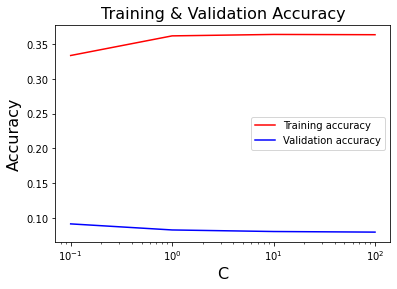

In [19]:
import matplotlib.pyplot as plt
 
C = np.asarray([0.1, 1, 10, 100])

plt.plot(C, clf.cv_results_['mean_train_score'], 'r', label='Training accuracy')
plt.plot(C, clf.cv_results_['mean_test_score'], 'b', label='Validation accuracy')
plt.title('Training & Validation Accuracy', fontsize=16)
plt.xlabel('C', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.xscale('log')
plt.legend()

check performance

In [29]:
# top 1 testing accuracy
np.mean(clf.best_estimator_.predict(X_test)==y_test)

0.09855207846800561